# Ex5 - Super Resolution

## Step 1: Create dataset

We would like to create a dataset for the training of a super-resolution network.

Our basic dataset for this task is the PascalVOC 2011 dataset which is available online
(https://pytorch.org/vision/0.8/datasets.html#voc). This dataset contains quality images, which is
very important for this task (in comparison to MNIST or CIFAR). Personally, I worked with a
subset of this dataset in order to see results faster, without overfitting (1000-200 images for
training and validation respectively).


** Pay attention that in this task you do not need the labels and they are actually interrupting in
loading a batch (the labels are different in their size). Attached is a function you can use in order
to change the labels to have the same size.


For the training, we need pairs of images: low-resolution and its high-resolution version. In this
exercise we will apply super resolution from 120x120x3 to 240x240x3.


In order to create the dataset, you can take one of the following options:
- Save these different sizes to disk
- create them on-the-fly in the training process. The DataLoader loads only the
high-resolution-images, and at every iteration you create the low-resolution one by
resizing it.
- Create your own CustomDataLoader that loads two images at the same time
(train,gt)->(low-resolution-image, high-resolution-image).


We encourage you to present some of the input and output images. For that, you can use
plt.figure(figsize=(12,12),dpi=300)

In [1]:
%matplotlib inline
import warnings
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
!mkdir -p data/train/high
!mkdir -p data/train/low
!mkdir -p data/val/high
!mkdir -p data/val/low

RES_HIGH = "high_res"
RES_LOW = "low_res"

ds_transforms = {
    RES_LOW: transforms.Compose(
    [transforms.Resize((120, 120)),
     transforms.Resize((240, 240), interpolation = Image.BILINEAR),
     transforms.ToTensor()]),

     RES_HIGH: transforms.Compose(
    [transforms.Resize((240, 240)),
     transforms.ToTensor()])
}


ds = {
    "train":
    {
        RES_HIGH: torchvision.datasets.VOCSegmentation(root='./data/train/high', year='2011', image_set='train', download=True, transform=ds_transforms[RES_HIGH]),
        RES_LOW: torchvision.datasets.VOCSegmentation(root='./data/train/low', year='2011', image_set='train', download=True, transform=ds_transforms[RES_LOW])
    },

    "test": {
        RES_HIGH: torchvision.datasets.VOCSegmentation(root='./data/val/high', year='2011', image_set='val', download=True, transform=ds_transforms[RES_HIGH]),
        RES_LOW: torchvision.datasets.VOCSegmentation(root='./data/val/low', year='2011', image_set='val', download=True, transform=ds_transforms[RES_LOW])
    } 
}

Using downloaded and verified file: ./data/train/high/VOCtrainval_25-May-2011.tar
Extracting ./data/train/high/VOCtrainval_25-May-2011.tar to ./data/train/high
Using downloaded and verified file: ./data/train/low/VOCtrainval_25-May-2011.tar
Extracting ./data/train/low/VOCtrainval_25-May-2011.tar to ./data/train/low
Using downloaded and verified file: ./data/val/high/VOCtrainval_25-May-2011.tar
Extracting ./data/val/high/VOCtrainval_25-May-2011.tar to ./data/val/high
Using downloaded and verified file: ./data/val/low/VOCtrainval_25-May-2011.tar
Extracting ./data/val/low/VOCtrainval_25-May-2011.tar to ./data/val/low


#### Let's print some images we loaded

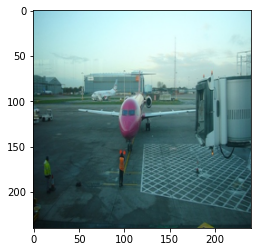

In [3]:
plt.imshow(ds['train'][RES_HIGH][0][0].permute(1, 2, 0))
plt.show()

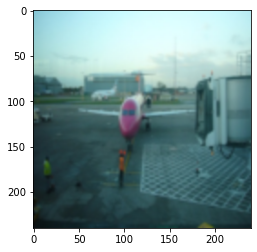

In [4]:
plt.imshow(ds['train'][RES_LOW][0][0].permute(1, 2, 0))
plt.show()

#### Create the dataloaders

In [5]:
train_data = []
train_labels = []

for i in range(len(ds['train'][RES_HIGH])): 
    low_res_img = ds['train'][RES_LOW][i][0]
    high_res_img = ds['train'][RES_HIGH][i][0]
    
    train_data.append(low_res_img)
    train_labels.append(high_res_img)

    
test_data = []
test_labels = []
    
for i in range(len(ds['test'][RES_HIGH])): 
    low_res_img = ds['test'][RES_LOW][i][0]
    high_res_img = ds['test'][RES_HIGH][i][0]
    
    test_data.append(low_res_img)
    test_labels.append(high_res_img)
    

train_data = torch.stack(train_data)
train_labels = torch.stack(train_labels)
test_data = torch.stack(test_data)
test_labels = torch.stack(test_labels)

In [6]:
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

In [7]:
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=16, shuffle=True),
    'val': DataLoader(test_dataset, batch_size=16, shuffle=False)
  }

In [8]:
dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset)}
print('dataset_sizes: ', dataset_sizes)

dataset_sizes:  {'train': 1112, 'val': 1111}


#### Validate the dataloaders work

In [9]:
samples, labels = next(iter(dataloaders['train']))

In [10]:
samples.shape

torch.Size([16, 3, 240, 240])

In [11]:
labels.shape

torch.Size([16, 3, 240, 240])

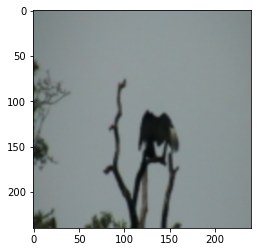

In [12]:
plt.imshow(torch.permute(samples[0], (1, 2, 0)))
plt.show()

## Step2: Create an inital model

In this step, we create the fully convolutional model with the architecture described below.

Our network works on the image that has the same size as the output. In other words, the input
image (120x120x3) is rescaled to be in the output size (240x240x3, use ‘bilinear’ flag) before it
is feeded to the network (or as the first layer of the network).

This results in a blurry 240x240x3 image that does not have the details as the ground truth has.
We can say that the purpose of the network is to de-blur the input image and add the details the
blurry image doesn't have. This is not an easy task.


Architecture:

We will follow a modified version of the SRCNN architecture - "Image Super-Resolution Using
Deep Convolutional Networks" (2015, https://arxiv.org/pdf/1501.00092.pdf) with 3 layers:

(1) Conv (9x9 @ 64),
(2) ReLU, (2) Conv (5x5 @ 32), ReLU,
(3) Conv (5x5 @ 3)

** @ is the number of filters.

** Make sure the image size does not change during the process (use padding)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
class BaseNetwork(nn.Module):
    def __init__(self):
        super(BaseNetwork, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=5, stride=1, padding=2),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        return x

In [15]:
model = BaseNetwork().to(device)
print(model)

BaseNetwork(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
  )
)


In [16]:
# !pip install torchsummary 

from torchsummary import summary
summary(model.to(device), (3, 240, 240))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 240, 240]          15,616
              ReLU-2         [-1, 64, 240, 240]               0
            Conv2d-3         [-1, 32, 240, 240]          51,232
              ReLU-4         [-1, 32, 240, 240]               0
            Conv2d-5          [-1, 3, 240, 240]           2,403
              ReLU-6          [-1, 3, 240, 240]               0
Total params: 69,251
Trainable params: 69,251
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.66
Forward/backward pass size (MB): 87.01
Params size (MB): 0.26
Estimated Total Size (MB): 87.94
----------------------------------------------------------------


##### Define the VGG Perceptual Loss network

In [17]:
from collections import namedtuple
 

loss_output = namedtuple("loss_output", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"])

class LossNetwork(torch.nn.Module):
    def __init__(self, vgg_model):
        super(LossNetwork, self).__init__()
        self.vgg_layers = vgg_model.features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3",
            '22': "relu4_3"
        }
    
    def forward(self, x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return loss_output(**output)


## Step 3: Training the model

In this step we finally train the model.

(1) We train the model using your favorite optimizer and MSE-loss.

![alt text](Ex5_step3a.png "")

(2) We will train the model with the addition of perceptual loss to the regular MSE-loss

By feeding a pre-trained vgg-16 network with the network output (240x240x3), you get
the image activations. Usually the activations that are taking into account for the
perceptual loss are: relu1_2, relu2_2, relu3_3, relu4_3. This should be done also for the
ground-truth image.

Then, the perceptual loss is defined as the MSE-loss between the activations of the
output and the ground-truth.

A visualization of the process is described below.

![alt text](Ex5_step3b.png "")

relu1_2, relu2_2, relu3_3, conv4_3,

relu1_2, relu2_2, relu3_3, conv4_3,

This task has multiple losses and you should balance them. Play with the weights of the losses
and consider even putting a weights=0 if you see that for example the relu4_3 part of the loss
does not help for the results.

**Evaluating your model:**

There is no good metric to evaluate the quality of the super resolution output image (so far...).
There are some metrics such as SSIM and PSNR but not something that is worth checking for
this exercise. Please assess your network and output by printing the loss(es) and presenting the
output images.

**More comments:**

1) The *colors* of the output image might be a bit different. This is a common issue that
papers report. As a post process usually they match the output histogram to the input.
You should not worry about it - do not put emphasis on the colors and focus on the
details and the sharpness of your output images.
2) This is a very hard task to solve, and we use a very very small and basic network in
order to make it applicable for you to train in minutes. Do not expect to have great results
(not even close to it). Compare your results to the input image which should be blurry
and not to the ground-truth image :)

In [18]:
def train_model(model, vgg_model, dataloaders, criterion, loss_weights, optimizer, scheduler, num_epochs=25):
    """
    Main training function
    """
    
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    results = {
                'train': 
                    {
                        'mse_loss': [],
                        'perceptual_loss': [],
                        'total_loss': []
                    },
                'val': 
                    {
                        'mse_loss': [],
                        'perceptual_loss': [],
                        'total_loss': []
                    }
    }

    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.
            running_mse = 0.
            running_perceptual = 0.
            running_relu1_2 = 0.
            running_relu2_2 = 0.
            running_relu3_3 = 0.
            running_relu4_3 = 0.

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    mse_loss = criterion(outputs, labels)
                    
                    # Get the perceptual loss
                    ground_truth_vgg = vgg_model(inputs)
                    base_output_vgg = vgg_model(outputs)
                    
                    relu1_2_se = ((ground_truth_vgg.relu1_2 - base_output_vgg.relu1_2)**2).sum().data
                    relu2_2_se = ((ground_truth_vgg.relu2_2 - base_output_vgg.relu2_2)**2).sum().data
                    relu3_3_se = ((ground_truth_vgg.relu3_3 - base_output_vgg.relu3_3)**2).sum().data
                    relu4_3_se = ((ground_truth_vgg.relu4_3 - base_output_vgg.relu4_3)**2).sum().data
                    
                    perceptual_loss = (
                        (loss_weights['relu1_2'] * relu1_2_se) + 
                        (loss_weights['relu2_2'] * relu2_2_se) + 
                        (loss_weights['relu3_3'] * relu3_3_se) +  
                        (loss_weights['relu4_3'] * relu4_3_se)
                    ) / 16. # Divide SE by batch size to get MSE
                    
                    loss = (loss_weights['mse'] * mse_loss) + perceptual_loss                  

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item()
                running_mse += mse_loss.item()
                running_perceptual += perceptual_loss.item()
                running_relu1_2 += relu1_2_se.item()
                running_relu2_2 += relu2_2_se.item()
                running_relu3_3 += relu3_3_se.item()
                running_relu4_3 += relu4_3_se.item()
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  
            
            # Evaluate entire epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_mse = running_mse / dataset_sizes[phase]
            epoch_perceptual = running_perceptual / dataset_sizes[phase]
            epoch_relu1_2 = running_relu1_2 / dataset_sizes[phase]
            epoch_relu2_2 = running_relu2_2 / dataset_sizes[phase]
            epoch_relu3_3 = running_relu3_3 / dataset_sizes[phase]
            epoch_relu4_3 = running_relu4_3 / dataset_sizes[phase]
            
                           
            results[phase]['total_loss'].append(epoch_loss)
            results[phase]['mse_loss'].append(epoch_mse)
            results[phase]['perceptual_loss'].append(epoch_perceptual)

            print(f'\n{phase} results -\nFull Loss: {epoch_loss:.4f} MSE Loss: {epoch_mse:.4f} Perceptual Loss: {epoch_perceptual:.4f}')
            print(f'Detailed Perceptual Losses - ReLU1_2: {epoch_relu1_2:.4f} ReLU2_2: {epoch_relu2_2:.4f} ReLU3_3: {epoch_relu3_3:.4f} ReLU4_3: {epoch_relu4_3:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_mse < best_loss:
                best_loss = epoch_mse
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val base network MSE loss: {epoch_mse:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, results


In [19]:
# Define the base network
model = BaseNetwork().to(device)
# MSE loss
criterion = nn.MSELoss(reduction='sum')
# Adam optimizer
optimizer_ft = optim.Adam(model.parameters())
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
num_epochs = 15


# Define the loss network
vgg_model = torchvision.models.vgg16(pretrained=True)
if torch.cuda.is_available():
    vgg_model.cuda()
loss_network = LossNetwork(vgg_model)
loss_network.eval()


# Define loss weights - Here I used same weight for all losses
loss_weights = {
    'mse': 1.,
    'relu1_2': 1.,
    'relu2_2': 1.,
    'relu3_3': 1.,
    'relu4_3': 1.
}

# Run the training
model, results = train_model(model, loss_network, dataloaders, criterion, loss_weights, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)


Epoch 0/14
----------

train results -
Full Loss: 137464.8307 MSE Loss: 3534.5747 Perceptual Loss: 133930.2558
Detailed Perceptual Losses - ReLU1_2: 212590.9395 ReLU2_2: 679001.9541 ReLU3_3: 1079202.2253 ReLU4_3: 172088.9859

val results -
Full Loss: 96868.1757 MSE Loss: 1085.0057 Perceptual Loss: 95783.1699
Detailed Perceptual Losses - ReLU1_2: 104628.7542 ReLU2_2: 485341.4694 ReLU3_3: 807455.4419 ReLU4_3: 135105.0520

Epoch 1/14
----------

train results -
Full Loss: 72756.1711 MSE Loss: 741.1607 Perceptual Loss: 72015.0100
Detailed Perceptual Losses - ReLU1_2: 73427.3348 ReLU2_2: 357804.4029 ReLU3_3: 615378.2637 ReLU4_3: 105630.1555

val results -
Full Loss: 52730.8939 MSE Loss: 563.1842 Perceptual Loss: 52167.7099
Detailed Perceptual Losses - ReLU1_2: 47968.2051 ReLU2_2: 269716.7655 ReLU3_3: 440905.7507 ReLU4_3: 76092.6377

Epoch 2/14
----------

train results -
Full Loss: 43562.4584 MSE Loss: 501.1492 Perceptual Loss: 43061.3092
Detailed Perceptual Losses - ReLU1_2: 36075.9304 Re

In [20]:
# Define the base network
model2 = BaseNetwork().to(device)
# MSE loss
criterion = nn.MSELoss(reduction='sum')
# Adam optimizer
optimizer_ft = optim.Adam(model2.parameters())
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
num_epochs = 15


# Define the loss network
vgg_model = torchvision.models.vgg16(pretrained=True)
if torch.cuda.is_available():
    vgg_model.cuda()
loss_network = LossNetwork(vgg_model)
loss_network.eval()


# Define loss weights - Here I played with different weights to understand the impact of each part
loss_weights = {
    'mse': 2.,
    'relu1_2': 0.5,
    'relu2_2': 0.2,
    'relu3_3': 0.1,
    'relu4_3': 0.1
} 

# Run the training
model2, results2 = train_model(model2, loss_network, dataloaders, criterion, loss_weights, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)


Epoch 0/14
----------

train results -
Full Loss: 33379.4527 MSE Loss: 4150.6155 Perceptual Loss: 25078.2218
Detailed Perceptual Losses - ReLU1_2: 276686.5646 ReLU2_2: 675070.4067 ReLU3_3: 1105607.7590 ReLU4_3: 173334.0801

val results -
Full Loss: 15523.5494 MSE Loss: 948.9936 Perceptual Loss: 13625.5622
Detailed Perceptual Losses - ReLU1_2: 91576.3769 ReLU2_2: 429460.6544 ReLU3_3: 739949.5779 ReLU4_3: 123337.1560

Epoch 1/14
----------

train results -
Full Loss: 10395.5819 MSE Loss: 618.2123 Perceptual Loss: 9159.1574
Detailed Perceptual Losses - ReLU1_2: 57421.0015 ReLU2_2: 292381.2571 ReLU3_3: 506444.2997 ReLU4_3: 87153.3316

val results -
Full Loss: 8522.4280 MSE Loss: 517.9434 Perceptual Loss: 7486.5411
Detailed Perceptual Losses - ReLU1_2: 46693.6784 ReLU2_2: 246730.4779 ReLU3_3: 402339.6215 ReLU4_3: 68577.5844

Epoch 2/14
----------

train results -
Full Loss: 7117.6133 MSE Loss: 431.9175 Perceptual Loss: 6253.7783
Detailed Perceptual Losses - ReLU1_2: 35553.1102 ReLU2_2: 213

In [21]:
# MSE - train: 231 val: 246
# loss_weights = {
#     'mse': 1.,
#     'relu1_2': 1.,
#     'relu2_2': 1.,
#     'relu3_3': 1.,
#     'relu4_3': 1.
# } 

# MSE - train: 224 val: 238
# loss_weights = {
#     'mse': 2.,
#     'relu1_2': 0.5,
#     'relu2_2': 0.2,
#     'relu3_3': 0.1,
#     'relu4_3': 0.1
# } 


# MSE - train: 243 val: 258
# loss_weights = {
#     'mse': 1.,
#     'relu1_2': 1,
#     'relu2_2': 0.5,
#     'relu3_3': 0.3,
#     'relu4_3': 0.1
# }

# MSE - train: 263  val: 273
# loss_weights = {
#     'mse': 3.,
#     'relu1_2': 1.,
#     'relu2_2': 1.,
#     'relu3_3': 1.,
#     'relu4_3': 1.
# } 


# MSE - train: 267  val: 284
# loss_weights = {
#     'mse': 5.,
#     'relu1_2': 0.5,
#     'relu2_2': 0.2,
#     'relu3_3': 0.1,
#     'relu4_3': 0.1
# } 

In [22]:
final_model = model2
final_results = results2

# Step 4: Summary

You should report your MSE and the perceptual loss in two different graphs. 

Visualize also a subplot of input, output and ground-truth images.

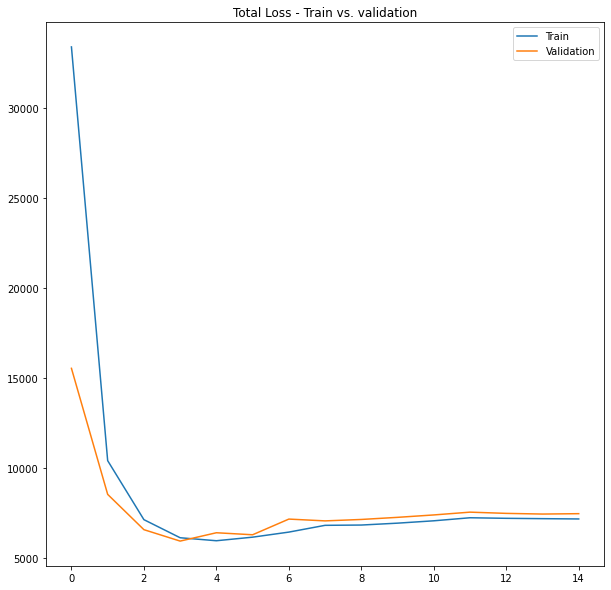

In [23]:
# Plotting the total loss graph
plt.figure(figsize=(10,10))
plt.plot(final_results['train']['total_loss'], label="Train")
plt.plot(final_results['val']['total_loss'], label= "Validation")
plt.legend()
plt.title('Total Loss - Train vs. validation')
plt.show()

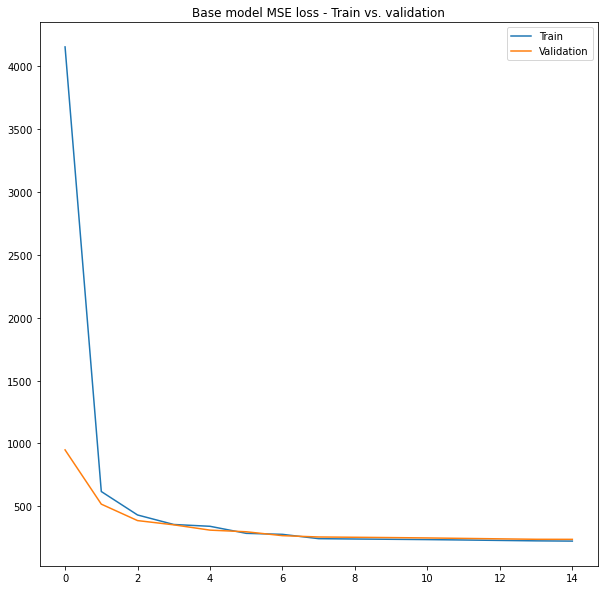

In [24]:
# Plotting the base network MSE graph
plt.figure(figsize=(10,10))
plt.plot(final_results['train']['mse_loss'], label="Train")
plt.plot(final_results['val']['mse_loss'], label= "Validation")
plt.legend()
plt.title('Base model MSE loss - Train vs. validation')
plt.show()

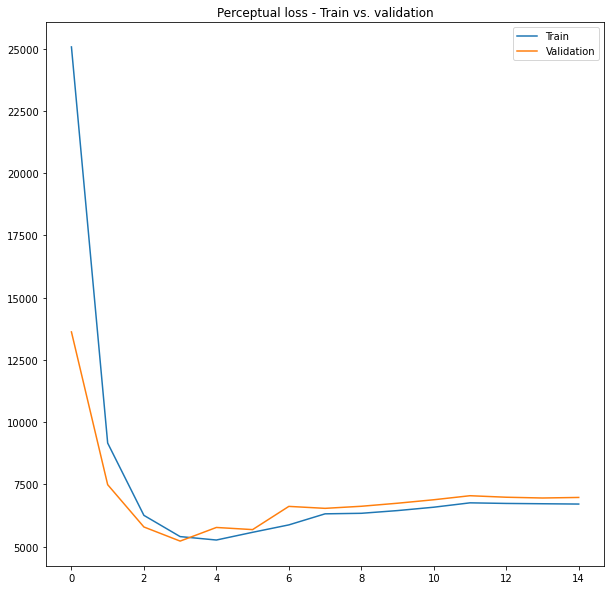

In [25]:
# Plotting the perceptual loss graph
plt.figure(figsize=(10,10))
plt.plot(final_results['train']['perceptual_loss'], label="Train")
plt.plot(final_results['val']['perceptual_loss'], label= "Validation")
plt.legend()
plt.title('Perceptual loss - Train vs. validation')
plt.show()

##### Visualize a subplot of the ground truth vs. input vs. outputs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

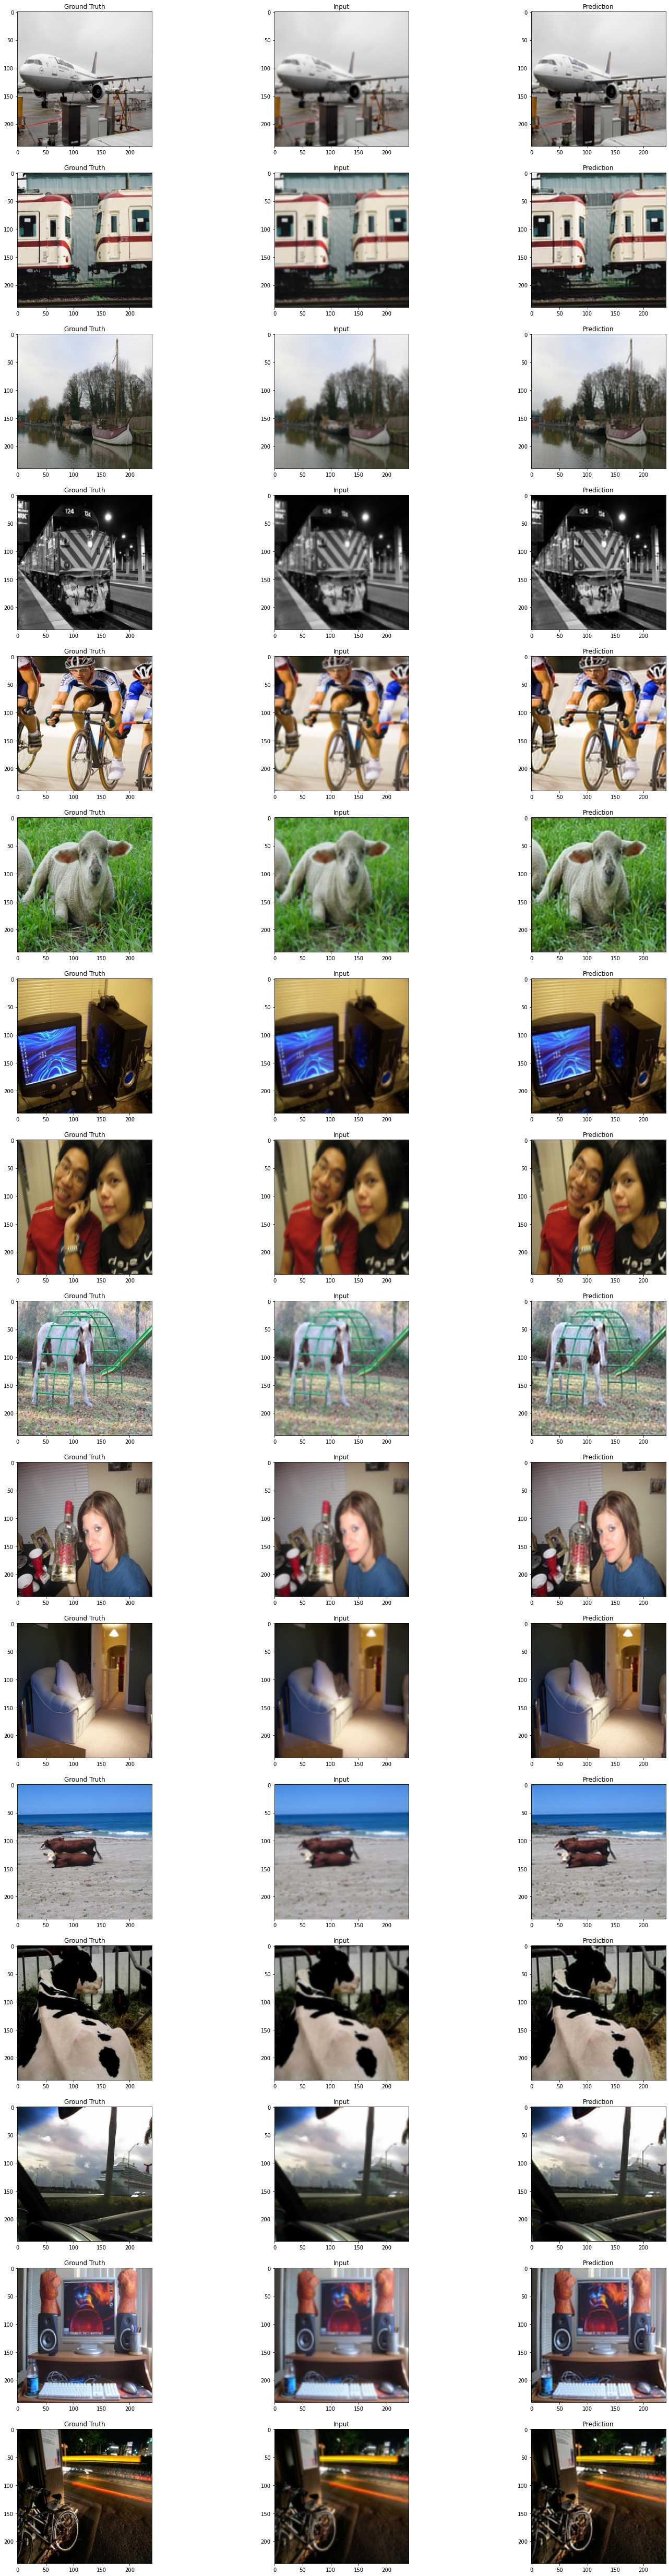

In [26]:
inputs, labels = next(iter(dataloaders['val']))

inputs = inputs.to(device)
labels = labels.to(device)
outputs = final_model(inputs)

fig, axes = plt.subplots(inputs.shape[0], 3, figsize=(25, 90))

for i in range(inputs.shape[0]):
    image_gd = torchvision.utils.make_grid(labels.cpu()[i], nrow=1)
    image_gd = image_gd.permute(1, 2, 0).detach().numpy()
    image_input = torchvision.utils.make_grid(inputs.cpu()[i], nrow=1)
    image_input = image_input.permute(1, 2, 0).detach().numpy()
    image_pred = torchvision.utils.make_grid(outputs.cpu()[i], nrow=1)
    image_pred = image_pred.permute(1, 2, 0).detach().numpy()

    axes[i,0].imshow(image_gd)
    axes[i,0].set_title("Ground Truth")
    axes[i,1].imshow(image_input)
    axes[i,1].set_title("Input")
    axes[i,2].imshow(image_pred)
    axes[i,2].set_title("Prediction")
plt.show()